In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from lib import Compressors
import torch
import matplotlib.pyplot as plt
import tqdm

size = 16
size_label = 14
dig_size = 12

In [ ]:
m = 50
sizes = [16, 50, 100, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000]
r = 8
k = 100
# k = 1

def clc(m, n, distribution, k):
    orig = [0, 0]
    our = [0, 0]
    for _ in range(k):
        W = torch.rand((m, n)).to('cuda')
        X = distribution.sample((n, n)).to('cuda')
        
        A, B = Compressors.CORDA(W, X, r)
        T = A @ B
        our[0] += torch.norm(T) / k
        our[1] += torch.norm(W @ X - T @ X) / k

        A, B = Compressors.CORDA_ORIGINAL(W.to('cuda'), X, r)
        T = A @ B
        orig[0] += torch.norm(T) / k
        orig[1] += torch.norm(W @ X - T @ X) / k
        
    return orig, our

distribution = torch.distributions.Normal(loc=0.0, scale=1.0)

results_orig = []
results_our = []

for size in tqdm.tqdm(sizes):
    orig, our = clc(m, size, distribution, k)
    results_orig.append(orig)
    results_our.append(our)

100%|██████████| 12/12 [12:41<00:00, 63.50s/it] 


In [10]:
orig_norms = [result[0].cpu() for result in results_orig]
orig_errors = [result[1].cpu() for result in results_orig]
our_norms = [result[0].cpu() for result in results_our]
our_errors = [result[1].cpu() for result in results_our]

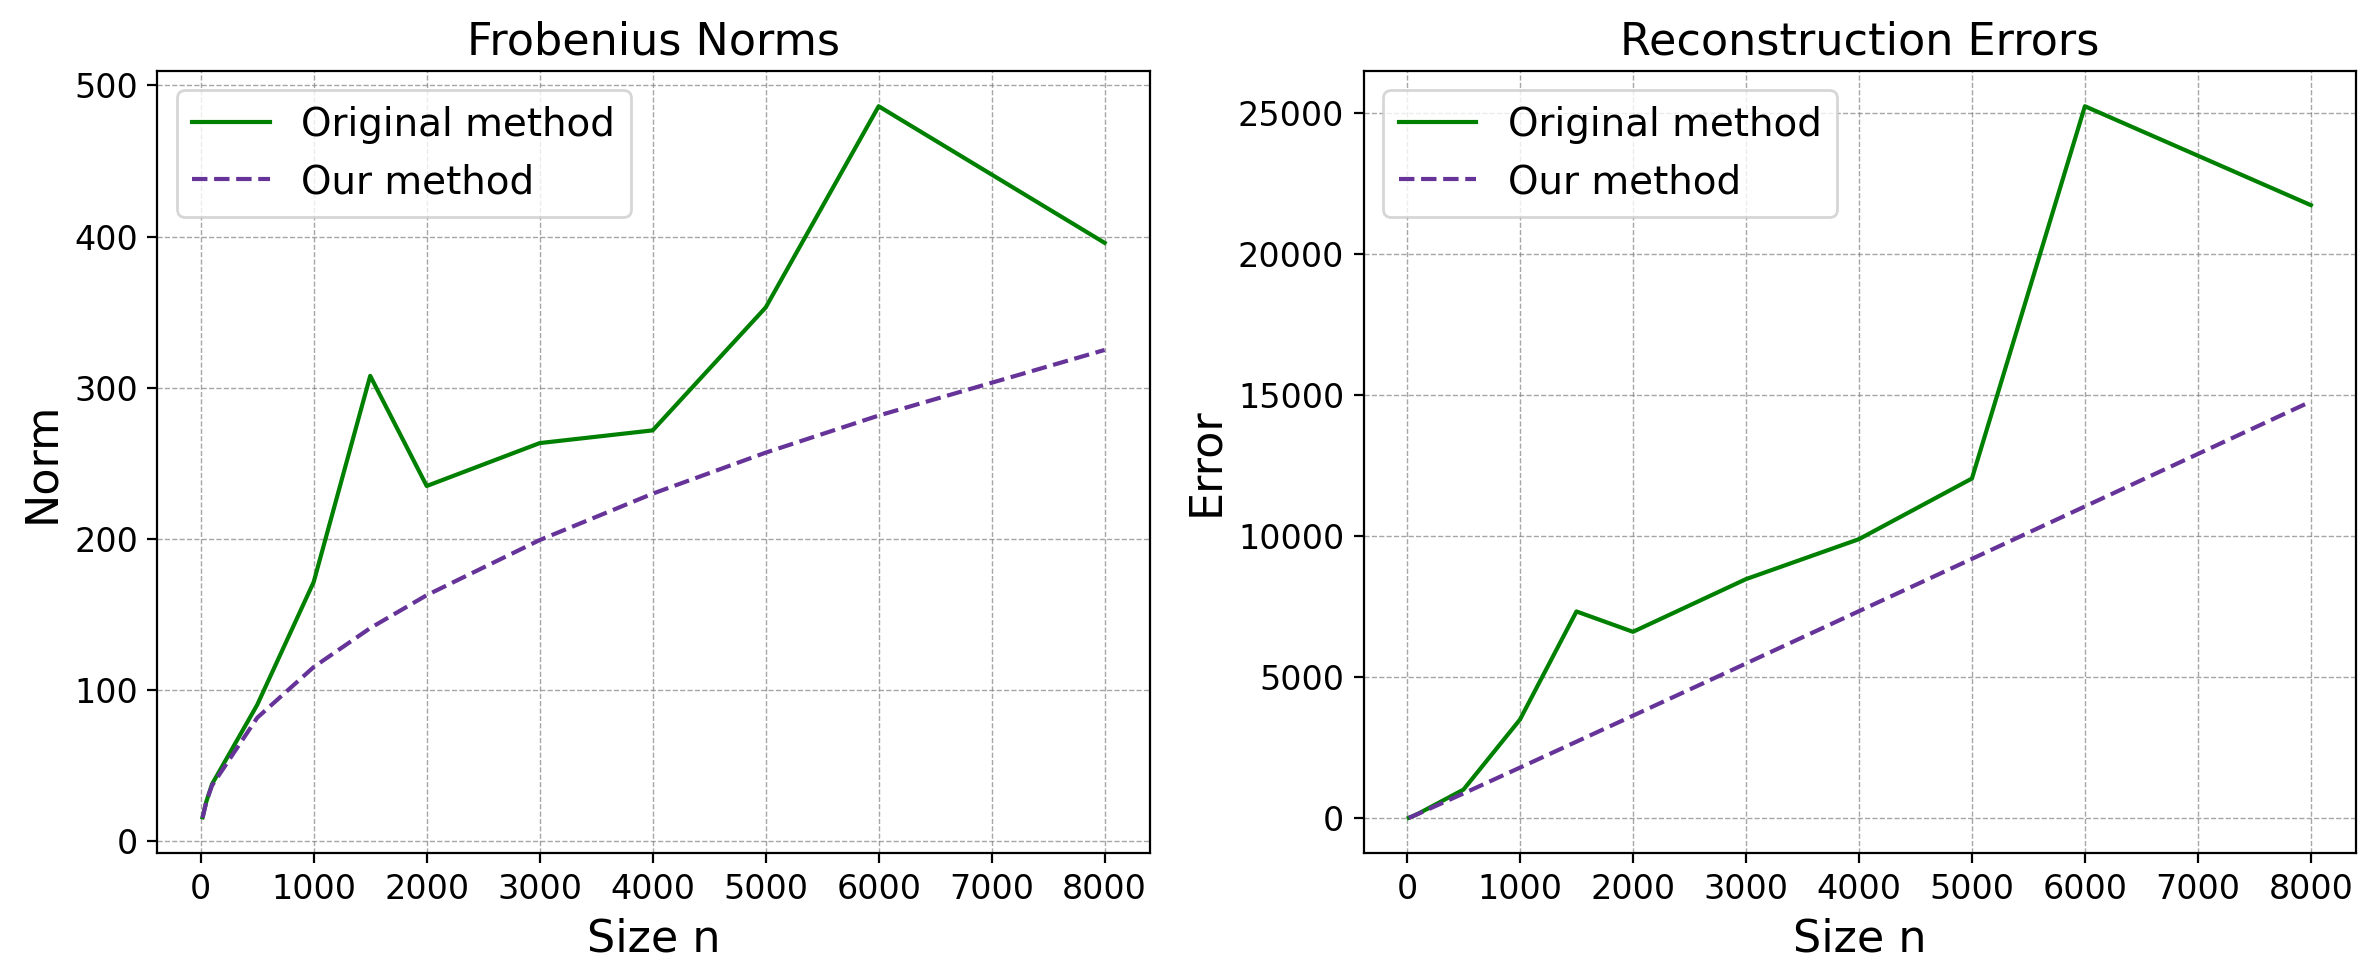

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
log_scale = True

color_B = 'rebeccapurple'
color_A = 'green'

axes[0].plot(sizes, orig_norms, label='Original method', color=color_A)
axes[0].plot(sizes, our_norms, label='Our method', linestyle='--', color=color_B)
    
axes[0].set_xlabel('Size n', fontsize=size)
axes[0].set_ylabel('Norm', fontsize=size)
axes[0].set_title('Frobenius Norms', fontsize=size)
axes[0].legend(fontsize=size_label)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=dig_size)

axes[1].plot(sizes, orig_errors, label='Original method', color=color_A)
axes[1].plot(sizes, our_errors, label='Our method', linestyle='--', color=color_B)
    
axes[1].set_xlabel('Size n', fontsize=size)
axes[1].set_ylabel('Error', fontsize=size)
axes[1].set_title('Reconstruction Errors', fontsize=size)
axes[1].legend(fontsize=size_label)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
axes[1].tick_params(axis='both', which='major', labelsize=dig_size)

plt.tight_layout()
plt.savefig('./images/orig_vs_our_normal.pdf', format='pdf', dpi=300)